In [4]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import os

device = torch.device('cpu')

model = models.resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(512, 1),
    nn.Sigmoid()
)
model.load_state_dict(torch.load('models/resnet18_best.pth', map_location=device))
model.eval()

print("Model loaded successfully")

Model loaded successfully


In [5]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, image_tensor):
        image_tensor = image_tensor.unsqueeze(0).to(device)
        image_tensor.requires_grad_()
        output = self.model(image_tensor)
        self.model.zero_grad()
        output.backward()
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        return cam.squeeze().cpu().numpy(), output.item()

gradcam = GradCAM(model, model.layer4[-1])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("GradCAM ready")

GradCAM ready


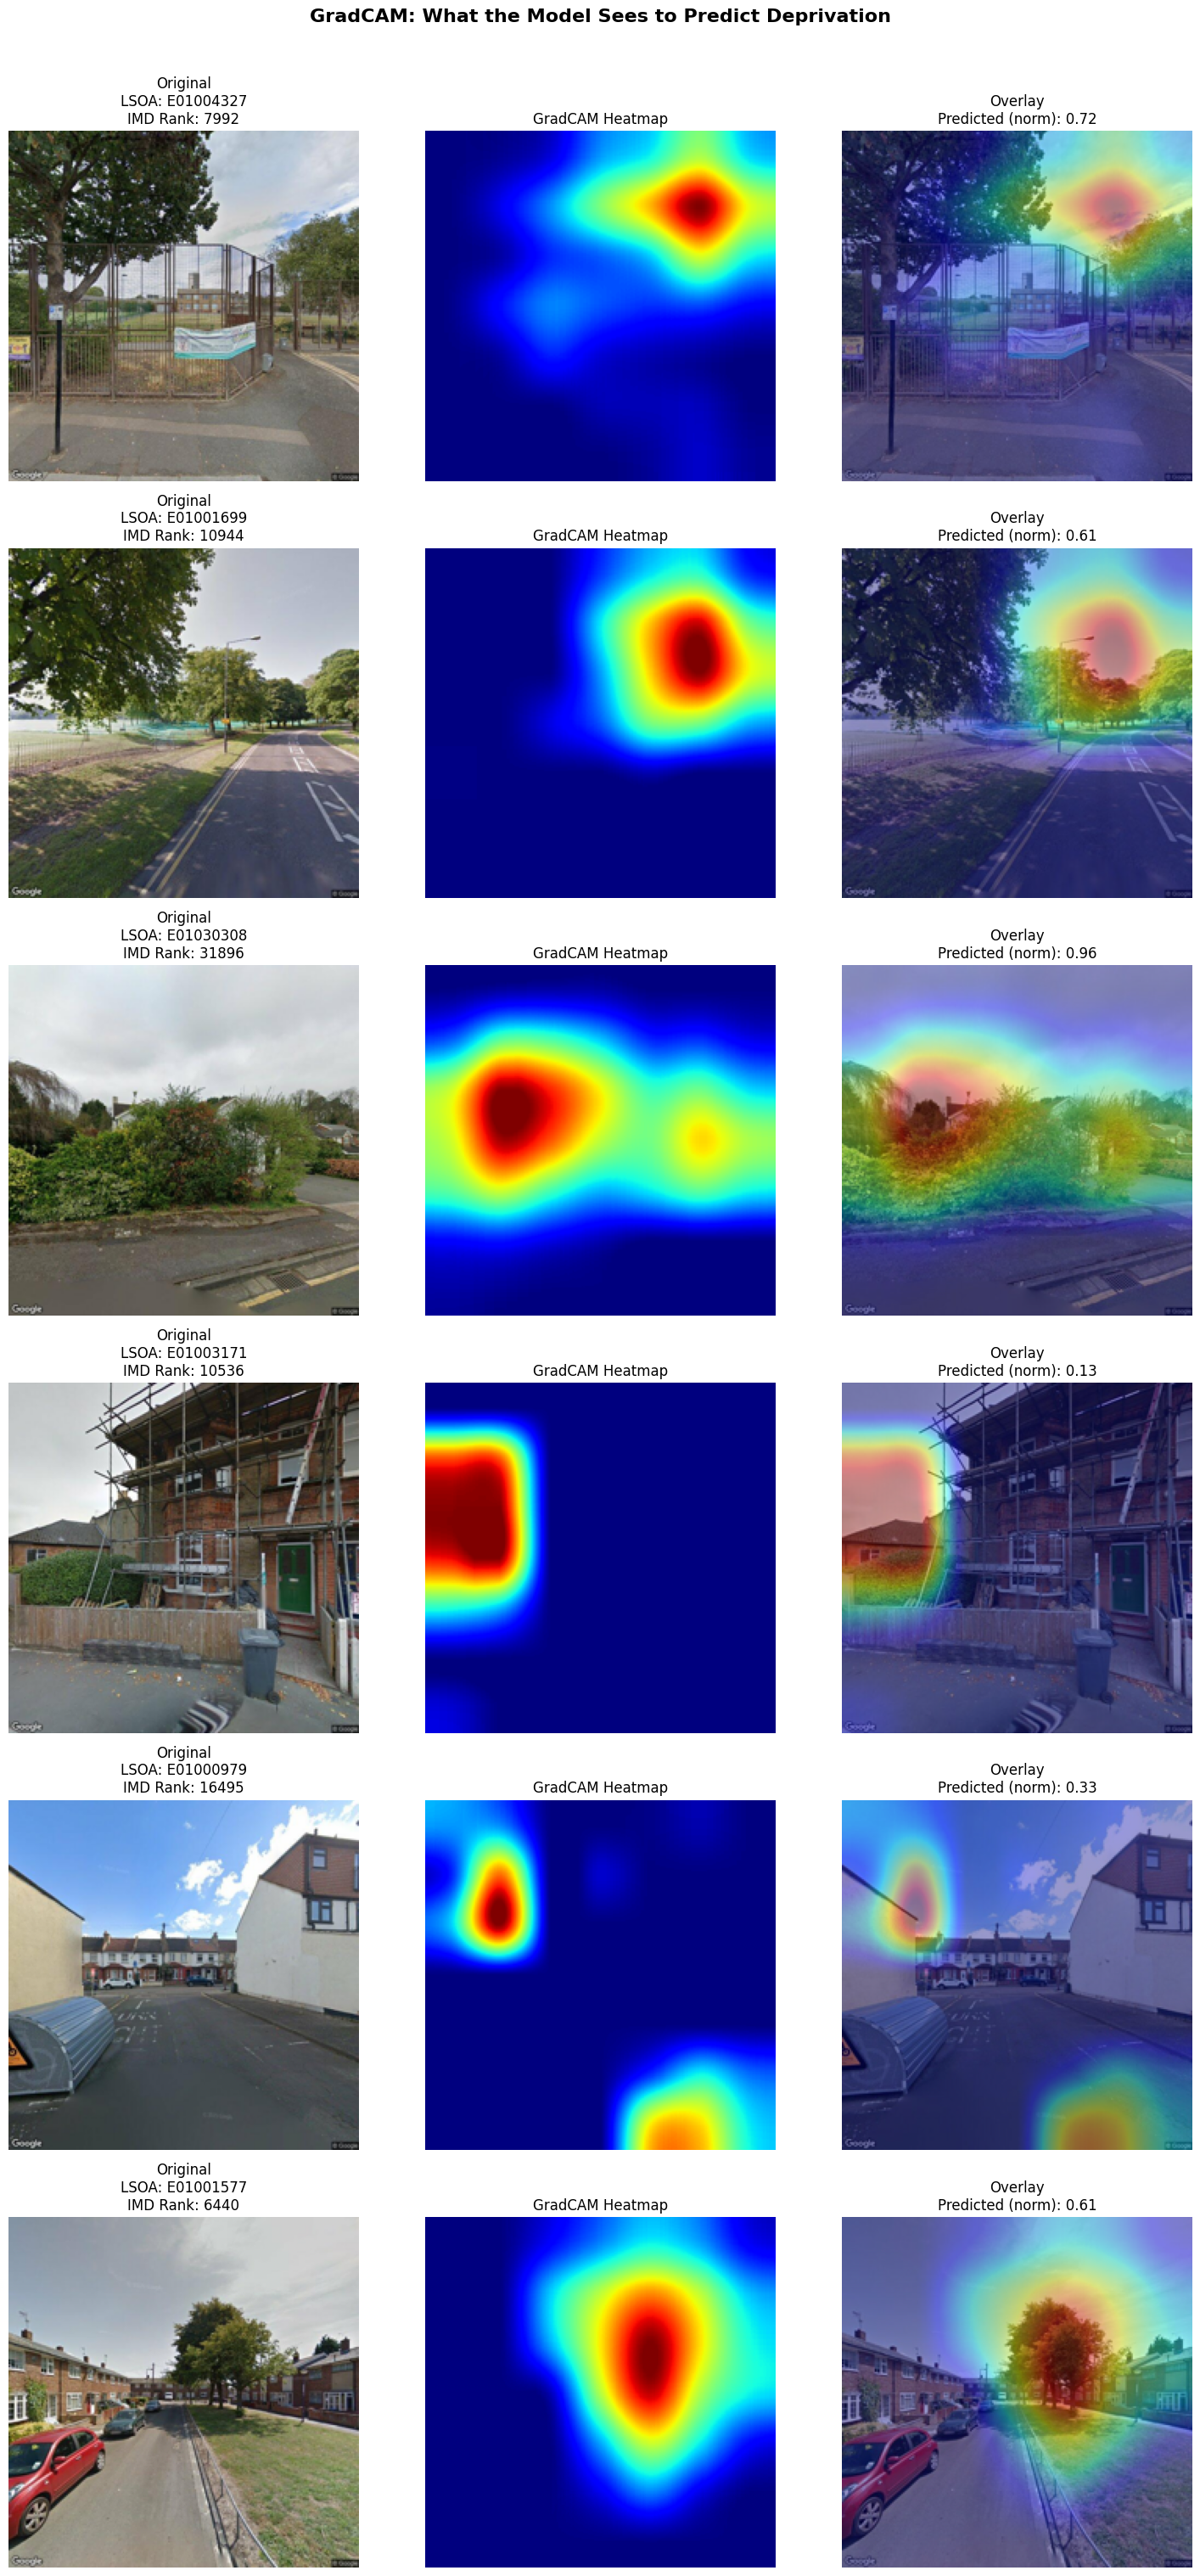

Saved to outputs/gradcam_results.png


In [6]:
lsoas = pd.read_csv('data/test_lsoas.csv')
image_dir = 'data/images/'

# Get all images except the test one
image_files = [f for f in os.listdir(image_dir) 
               if f.endswith('.jpg') and f != 'test_image.jpg'][:6]

fig, axes = plt.subplots(len(image_files), 3, figsize=(15, 5 * len(image_files)))

for i, fname in enumerate(image_files):
    path = os.path.join(image_dir, fname)
    lsoa_code = fname.rsplit('_', 1)[0]
    
    match = lsoas[lsoas['LSOA11CD'] == lsoa_code]
    true_score = match['IMD19'].values[0] if not match.empty else '?'

    img_original = Image.open(path).convert('RGB').resize((224, 224))
    img_tensor = transform(Image.open(path).convert('RGB'))
    
    cam, pred_norm = gradcam.generate(img_tensor)
    
    cam_img = Image.fromarray((cam * 255).astype(np.uint8)).resize((224, 224))
    cam_array = np.array(cam_img)
    
    heatmap = cm.jet(cam_array / 255.0)[:, :, :3]
    overlay = (np.array(img_original) / 255.0 * 0.6 + heatmap * 0.4)
    overlay = np.clip(overlay, 0, 1)

    axes[i][0].imshow(img_original)
    axes[i][0].set_title(f'Original\nLSOA: {lsoa_code}\nIMD Rank: {true_score:.0f}')
    axes[i][0].axis('off')

    axes[i][1].imshow(cam_array, cmap='jet')
    axes[i][1].set_title('GradCAM Heatmap')
    axes[i][1].axis('off')

    axes[i][2].imshow(overlay)
    axes[i][2].set_title(f'Overlay\nPredicted (norm): {pred_norm:.2f}')
    axes[i][2].axis('off')

plt.suptitle('GradCAM: What the Model Sees to Predict Deprivation', 
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('outputs/gradcam_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved to outputs/gradcam_results.png")